In [1]:
import pandas as pd

# Correct direct download link
url = 'Fraud.csv'

# Read CSV
df = pd.read_csv(url)

# Preview
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
print(df['isFraud'].isnull().sum())


1


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    742394
         1.0       1.00      1.00      1.00    744349

    accuracy                           1.00   1486743
   macro avg       1.00      1.00      1.00   1486743
weighted avg       1.00      1.00      1.00   1486743

Confusion Matrix:
 [[741906    488]
 [    36 744313]]
ROC-AUC Score: 0.9996471513457955


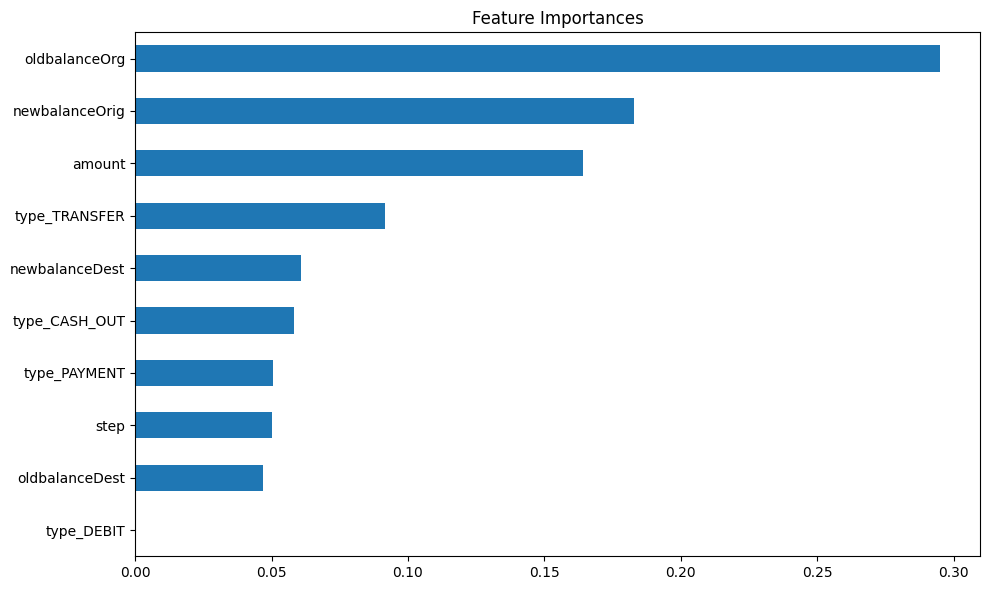

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('Fraud.csv')  # Replace with your actual file path

# 2. Drop ID columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# 3. Encode 'type' column (One-Hot Encoding)
df = pd.get_dummies(df, columns=['type'], drop_first=True)
# Drop rows where target is missing
df = df.dropna(subset=['isFraud'])

# If needed, check again
assert df['isFraud'].isnull().sum() == 0

# 4. Features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']  # Target = fraud indicator

# 5. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 8. Train RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 9. Predictions
y_pred = clf.predict(X_test)

# 10. Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# 11. Feature Importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


<Axes: xlabel='isFraud', ylabel='count'>

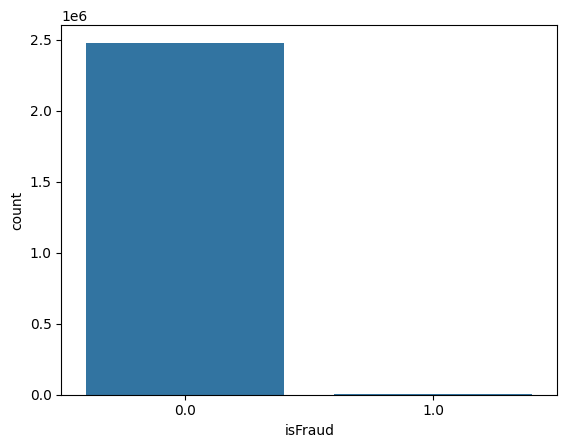

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of target variable
sns.countplot(x='isFraud', data=df)




In [20]:
training_columns = X.columns.tolist()
print(training_columns)



['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [19]:
def predict_transaction_final(clf, scaler, txn_dict, training_columns):
    import pandas as pd

    # Convert to DataFrame
    df = pd.DataFrame([txn_dict])

    # One-hot encode 'type'
    df = pd.get_dummies(df, columns=['type'])

    # Ensure all required columns exist
    for col in training_columns:
        if col not in df.columns:
            df[col] = 0

    # Remove extra columns
    df = df[training_columns]

    # Scale
    df_scaled = scaler.transform(df)

    # Predict
    pred = clf.predict(df_scaled)[0]
    return "Fraud" if pred == 1 else "Not Fraud"



txn = {
    'step': 1,
    'type': 'TRANSFER',
    'amount': 100000,
    'oldbalanceOrg': 100000,
    'newbalanceOrig': 0,
    'oldbalanceDest': 0,
    'newbalanceDest': 0
}


result = predict_transaction_final(clf, scaler, txn, training_columns)
print("Prediction:", result)


Prediction: Fraud
